In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Sparse Identification of Nonlinear Dynamics

Sparse Identification of Nonlinear Dynamics (SINDy) is a method to identify the governing equations of a dynamical system from data.
The method was introduced in [Brunton et al. (2016)](https://www.pnas.org/content/113/15/3932) and has since become very popular.
We are not going to outline the details of the method here.
These are covered in the hand-written notes.
Here we will replicate the results of the paper.
We refer the reader also the [Appendix of Brunton et al. (2016)](https://www.pnas.org/doi/suppl/10.1073/pnas.1517384113/suppl_file/pnas.1517384113.sapp.pdf) for more details.

## Example 1ai: Linear dynamics

Consider the linear system:

\begin{align}
\dot{x}_1 &= -0.1 x_1 + 2 x_2 \\
\dot{x}_2 &= -2 x_1 - 0.1 x_2
\end{align}

We will generate data from this system without noise, fit a high dimensional polynomial of fifth order and see if we can identify the coefficients correctly.

In [2]:
import numpy as np
import scipy

A = np.array([
    [-0.1, 2],
    [-2, -0.1]
])

ts = np.linspace(0.0, 25.0, 10_000)
x0 = np.array([2.0, 0.0])
xs = scipy.integrate.odeint(lambda x, t: A @ x, x0, ts)
dxs = A @ xs.T

Let's setup the regression problem.
We are going to solve a different one for $x_1$ and $x_2$.
We write:

$$
\dot{x}_j = f_j(\mathbf{x}) = \boldsymbol{\phi}^T(\mathbf{x})\boldsymbol{\theta}_j,
$$

where $\boldsymbol{\phi}(\mathbf{x})$ is a two-dimensional polynomial of fifth order and $\boldsymbol{\theta}_j$ are the coefficients we want to identify.

We will fit $\boldsymbol{\theta}_j$ by solving the following optimization problem:

$$
\min_{\boldsymbol{\theta}_j} \left\{
\|\dot{X}_j - \Phi\boldsymbol{\theta}_j\|^2 + \lambda \|\boldsymbol{\theta}_j\|_1
\right\},
$$

where $\dot{X}_j$ is the time derivative of $x_j$ and $\Phi$ is the matrix of $\boldsymbol{\phi}(\mathbf{x})$ evaluated at the data points (the design matrix).

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV

f_approx = PolynomialFeatures(degree=5)
Phi = f_approx.fit_transform(xs)

thetas = []
for j in range(2):
    clf = LassoCV(fit_intercept=False, n_alphas=10_000, eps=1e-5)
    dx = dxs[j, :]
    clf.fit(Phi, dx)
    thetas.append(clf.coef_)

And here are how the coefficients compare:

In [4]:
for j in range(2):
    print(f"Dynamics of x_{j+1}:")
    print("-" * 20)
    for i, name in enumerate(f_approx.get_feature_names_out()):
        print(f"{name:10} = {thetas[j][i]:.2f}")  

Dynamics of x_1:
--------------------
1          = -0.00
x0         = -0.11
x1         = 2.00
x0^2       = -0.00
x0 x1      = 0.00
x1^2       = 0.00
x0^3       = 0.01
x0^2 x1    = -0.00
x0 x1^2    = 0.01
x1^3       = 0.00
x0^4       = 0.00
x0^3 x1    = -0.00
x0^2 x1^2  = -0.00
x0 x1^3    = -0.00
x1^4       = -0.00
x0^5       = -0.00
x0^4 x1    = -0.00
x0^3 x1^2  = -0.00
x0^2 x1^3  = -0.00
x0 x1^4    = -0.00
x1^5       = -0.00
Dynamics of x_2:
--------------------
1          = 0.00
x0         = -2.00
x1         = -0.10
x0^2       = 0.00
x0 x1      = -0.00
x1^2       = -0.00
x0^3       = -0.00
x0^2 x1    = -0.00
x0 x1^2    = -0.00
x1^3       = -0.00
x0^4       = -0.00
x0^3 x1    = -0.00
x0^2 x1^2  = 0.00
x0 x1^3    = -0.00
x1^4       = -0.00
x0^5       = 0.00
x0^4 x1    = -0.00
x0^3 x1^2  = 0.00
x0^2 x1^3  = -0.00
x0 x1^4    = -0.00
x1^5       = -0.00


We observe an almost perfect identification of the dynamics.

Let's simulate the learned dynamics to see what we get.

In [5]:
def f_learned(x, t, thetas, f_approx):
    phi = f_approx.fit_transform(x.reshape(1, -1)).flatten()
    dx = np.zeros(x.shape[0])
    for j in range(x.shape[0]):
        dx[j] = np.dot(thetas[j], phi)
    return dx

xs_learned = scipy.integrate.odeint(lambda x, t: f_learned(x, t, thetas, f_approx), x0, ts)

Let's visualize the results:

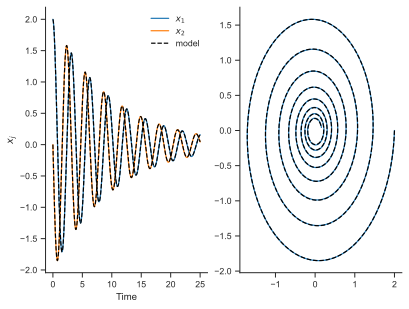

In [6]:
fig, ax = plt.subplots(1,2)
ax[0].plot(ts, xs[:,0], label="$x_1$")
ax[0].plot(ts, xs[:,1], label="$x_2$")
ax[0].plot(ts, xs_learned[:,0], 'k--', label="model")
ax[0].plot(ts, xs_learned[:,1], 'k--')
ax[0].set(xlabel="Time", ylabel="$x_j$")
ax[0].legend(loc='best', frameon=False)

ax[1].plot(xs[:,0], xs[:,1])
ax[1].plot(xs_learned[:,0], xs_learned[:,1], 'k--')

sns.despine();

This reproduces the left column of Fig. 2 of the Appendix of Brunton et al. (2016).

## Example 1aii: Cubic non-linearity

This example is as above, but with a cubic non-linearity:

\begin{align}
\dot{x}_1 &= -0.1 x_1^3 + 2 x_2^3 \\
\dot{x}_2 &= -2 x_1^3 - 0.1 x_2^3
\end{align}

Let's generate the data:

In [7]:
xs = scipy.integrate.odeint(lambda x, t: A @ (x ** 3), x0, ts)
dxs = A @ (xs ** 3).T

We fit the fifth degree polynomial just like before:

In [8]:
Phi = f_approx.fit_transform(xs)

thetas = []
for j in range(2):
    clf = LassoCV(fit_intercept=False, n_alphas=10_000, eps=1e-5)
    dx = dxs[j, :]
    clf.fit(Phi, dx)
    thetas.append(clf.coef_)

The coefficients:

In [9]:
for j in range(2):
    print(f"Dynamics of x_{j+1}:")
    print("-" * 20)
    for i, name in enumerate(f_approx.get_feature_names_out()):
        print(f"{name:10} = {thetas[j][i]:.2f}")  

Dynamics of x_1:
--------------------
1          = 0.00
x0         = -0.00
x1         = 0.00
x0^2       = -0.00
x0 x1      = 0.00
x1^2       = -0.00
x0^3       = -0.09
x0^2 x1    = 0.00
x0 x1^2    = 0.00
x1^3       = 2.00
x0^4       = 0.00
x0^3 x1    = -0.00
x0^2 x1^2  = -0.00
x0 x1^3    = 0.00
x1^4       = 0.00
x0^5       = -0.00
x0^4 x1    = -0.00
x0^3 x1^2  = -0.00
x0^2 x1^3  = 0.00
x0 x1^4    = 0.00
x1^5       = 0.00
Dynamics of x_2:
--------------------
1          = -0.00
x0         = 0.00
x1         = -0.00
x0^2       = 0.00
x0 x1      = 0.00
x1^2       = -0.00
x0^3       = -2.00
x0^2 x1    = 0.00
x0 x1^2    = -0.00
x1^3       = -0.10
x0^4       = -0.00
x0^3 x1    = 0.00
x0^2 x1^2  = -0.00
x0 x1^3    = 0.00
x1^4       = -0.00
x0^5       = 0.00
x0^4 x1    = 0.00
x0^3 x1^2  = -0.00
x0^2 x1^3  = -0.00
x0 x1^4    = 0.00
x1^5       = -0.00


And here are the predictions:

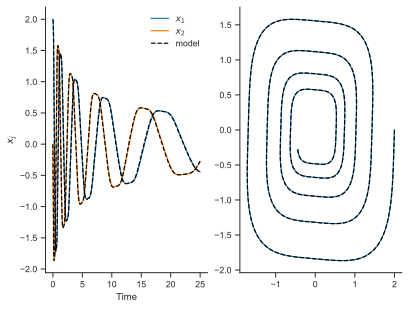

In [10]:
xs_learned = scipy.integrate.odeint(lambda x, t: f_learned(x, t, thetas, f_approx), x0, ts)

fig, ax = plt.subplots(1,2)
ax[0].plot(ts, xs[:,0], label="$x_1$")
ax[0].plot(ts, xs[:,1], label="$x_2$")
ax[0].plot(ts, xs_learned[:,0], 'k--', label="model")
ax[0].plot(ts, xs_learned[:,1], 'k--')
ax[0].set(xlabel="Time", ylabel="$x_j$")
ax[0].legend(loc='best', frameon=False)

ax[1].plot(xs[:,0], xs[:,1])
ax[1].plot(xs_learned[:,0], xs_learned[:,1], 'k--')

sns.despine();

This is the second column of Fig. 2 of the Appendix of Brunton et al. (2016).

## Example 1b: Three-dimensional linear system

The system is:

\begin{align}
\dot{x}_1 &= -0.1 x_1 -2x_2\\
\dot{x}_2 &= 2x_1 -0.1x_2\\
\dot{x}_3 &= -0.3x_3
\end{align}

Generate synthetic data:

In [11]:
B = np.array([
    [-0.1, -2., 0],
    [2, -0.1, 0],
    [0, 0, -0.3]
])
ts = np.linspace(0, 50, 2_000)
x0 = np.array([2.0, 0.0, 1.0])
xs = scipy.integrate.odeint(lambda x, t: B @ x, x0, ts)
dxs = B @ xs.T

Fit:

In [12]:
Phi = f_approx.fit_transform(xs)
thetas = []
for j in range(3):
    clf = LassoCV(fit_intercept=False, n_alphas=10_000, eps=1e-5)
    dx = dxs[j, :]
    clf.fit(Phi, dx)
    thetas.append(clf.coef_)

Coefficients:

In [13]:
for j in range(3):
    print(f"Dynamics of x_{j+1}:")
    print("-" * 20)
    for i, name in enumerate(f_approx.get_feature_names_out()):
        print(f"{name:10} =  {thetas[j][i]:.2f}")

Dynamics of x_1:
--------------------
1          =  -0.00
x0         =  -0.10
x1         =  -2.00
x2         =  0.00
x0^2       =  0.00
x0 x1      =  -0.00
x0 x2      =  -0.00
x1^2       =  -0.00
x1 x2      =  0.00
x2^2       =  0.00
x0^3       =  0.00
x0^2 x1    =  0.00
x0^2 x2    =  0.00
x0 x1^2    =  0.00
x0 x1 x2   =  0.00
x0 x2^2    =  0.00
x1^3       =  -0.00
x1^2 x2    =  -0.00
x1 x2^2    =  0.00
x2^3       =  0.00
x0^4       =  -0.00
x0^3 x1    =  0.00
x0^3 x2    =  -0.00
x0^2 x1^2  =  -0.00
x0^2 x1 x2 =  -0.00
x0^2 x2^2  =  -0.00
x0 x1^3    =  0.00
x0 x1^2 x2 =  0.00
x0 x1 x2^2 =  0.00
x0 x2^3    =  -0.00
x1^4       =  -0.00
x1^3 x2    =  -0.00
x1^2 x2^2  =  -0.00
x1 x2^3    =  -0.00
x2^4       =  -0.00
x0^5       =  -0.00
x0^4 x1    =  -0.00
x0^4 x2    =  0.00
x0^3 x1^2  =  -0.00
x0^3 x1 x2 =  0.00
x0^3 x2^2  =  0.00
x0^2 x1^3  =  -0.00
x0^2 x1^2 x2 =  -0.00
x0^2 x1 x2^2 =  -0.00
x0^2 x2^3  =  0.00
x0 x1^4    =  -0.00
x0 x1^3 x2 =  0.00
x0 x1^2 x2^2 =  -0.00
x0 x1 x2^3 =  0.0

Plots:

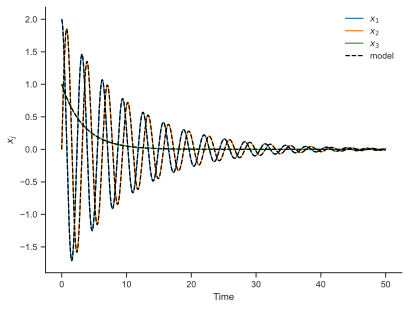

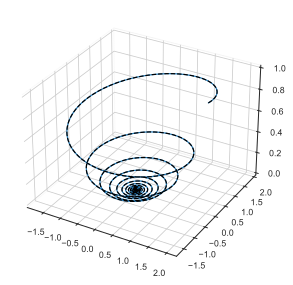

In [14]:
xs_learned = scipy.integrate.odeint(lambda x, t: f_learned(x, t, thetas, f_approx), x0, ts)

fig, ax = plt.subplots()
ax.plot(ts, xs[:,0], label="$x_1$")
ax.plot(ts, xs[:,1], label="$x_2$")
ax.plot(ts, xs[:,2], label="$x_3$")
ax.plot(ts, xs_learned[:,0], 'k--', label="model")
ax.plot(ts, xs_learned[:,1], 'k--')
ax.plot(ts, xs_learned[:,2], 'k--')
ax.set(xlabel="Time", ylabel="$x_j$")
ax.legend(loc='best', frameon=False)
sns.despine();

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs[:,0], xs[:,1], xs[:,2])
ax.plot(xs_learned[:,0], xs_learned[:,1], xs_learned[:,2], 'k--')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

This reproduces Fig. 3 of the Appendix of Brunton et al. (2016).